In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['flatten', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
import multiprocessing as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from operator import xor

In [12]:
from classifier import *
from ntk import *
from Q_minimization import *
from train import *

### Define Dimensions

In [13]:
n = 10
d = 3

### Define Setting

In [125]:
USE_RELU = True  # turn this off to move to linear activations

### Define Dataset

In [238]:
rho_1 = np.random.normal(size=(d, 1), loc=0.25, scale=1)
b_1 = np.random.normal(size=(1,), loc=10, scale=10)

plane_1 = lambda _x: np.matmul(rho_1.transpose(), _x) * b_1

In [239]:
if USE_RELU:
    gt = lambda _x: np.maximum(plane_1(_x), 0) # relu
else:
    gt = lambda _x: plane_1(_x)  # linear

In [240]:
x = np.random.normal(size=(d, n), loc=2, scale=1)
y = gt(x)

x.shape, y.shape

((3, 10), (1, 10))

In [241]:
y

array([[ 0.        , 19.20782489,  0.87170528, 12.26699544,  0.        ,
        11.46985788,  0.        ,  6.03119015,  6.2550207 ,  0.        ]])

In [242]:
if USE_RELU:
    assert sum(y) > 0   # we want some non-zero labels

### Empirical Gradient Flow

In [249]:
u_0, v_0, a_0 = symmetric_init(alpha=1, s=0, d=3, symmetric=False)
u_0, v_0, a_0

(array([[ 0.36196153],
        [ 0.71802838],
        [-0.59449062]]), array([[-0.82077217],
        [-0.39456552],
        [ 0.41309939]]), array([1.]))

In [250]:
if USE_RELU:
    assert a_0 > 0 # for ReLU

In [251]:
results = train(
    u_0=u_0,
    v_0=v_0,
    a_0=a_0,
    x=x,
    y=y,
    step_size=1e-5,
    n_epochs=500000,
    eval_freq=1000,
    relu=USE_RELU)

100%|██████████| 500000/500000 [00:09<00:00, 51713.69it/s]


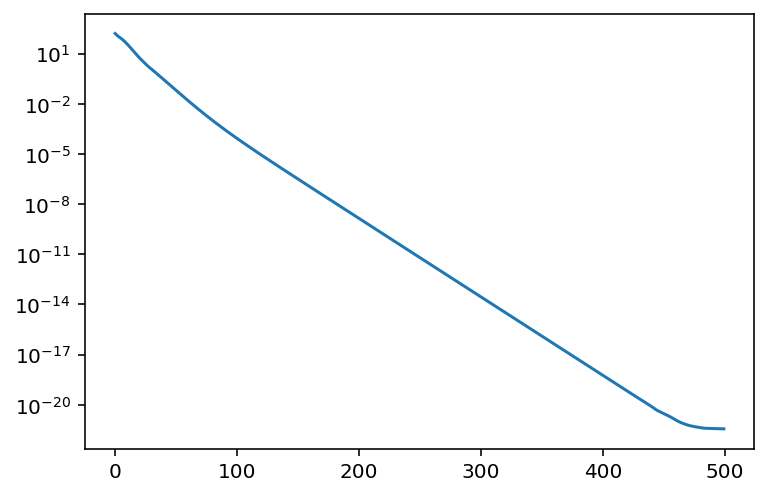

In [252]:
plot(results['training_loss'])
yscale('log')

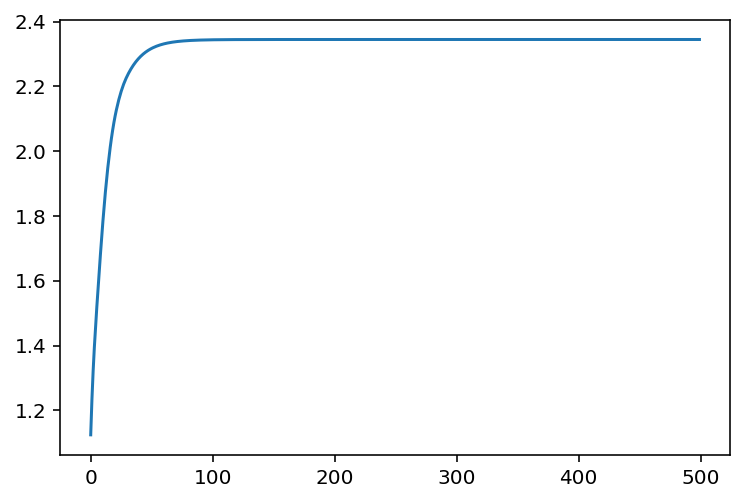

In [253]:
plot([a[0][0] for a in results['a']])

In [254]:
results['training_loss'][-1]

3.6393836794401475e-22

### Estimate Q Minimization

In [255]:
w_opt_Q = solver(x, y, u_0, v_0, a_0, obj='Q', optim_tol=1e-4, relu=USE_RELU)

In [256]:
w_0 = ((u_0 - v_0) * a_0).reshape(-1,)
w_GD = ((results['u'][-1] - results['v'][-1]) * results['a'][-1]).reshape(-1, )
w_0, w_GD

(array([ 1.18273369,  1.1125939 , -1.00759001]),
 array([ 6.53599434,  0.50837829, -5.15760844]))

In [257]:
w_opt_Q, w_GD

(array([ 6.53599001,  0.50845506, -5.15765086]),
 array([ 6.53599434,  0.50837829, -5.15760844]))

In [258]:
print(
    q_func(w_0.reshape(-1, 1), a_0, u_0, v_0),
    q_func(w_GD.reshape(-1, 1), a_0, u_0, v_0),
    q_func(w_opt_Q.reshape(-1, 1), a_0, u_0, v_0)
)

[15.64179434] [22.66805075] [22.6674828]


In [259]:
if USE_RELU:
    y_pred_GD = np.maximum(np.matmul((results['u'][-1] - results['v'][-1]).transpose(), x), 0) * results['a'][-1]
else:
    y_pred_GD = np.matmul(w_GD.transpose(), x)
y_pred_GD    

array([[ 0.        , 19.20782489,  0.87170528, 12.26699544,  0.        ,
        11.46985788,  0.        ,  6.03119015,  6.2550207 ,  0.        ]])

In [260]:
y_pred_Q = np.matmul(w_opt_Q.transpose(), x)
y_pred_Q

array([-4.73129765, 19.20792489,  0.87180508, 12.26689544, -2.66664596,
       11.46985522, -2.45736275,  6.03129015,  6.25507419, -1.36503289])

In [261]:
y

array([[ 0.        , 19.20782489,  0.87170528, 12.26699544,  0.        ,
        11.46985788,  0.        ,  6.03119015,  6.2550207 ,  0.        ]])